In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.autonotebook import tqdm
from IPython import display
from scipy.io import wavfile
from tensorflow.keras import layers
from tensorflow import keras
import processing as pr

/tmp/ipykernel_2268927/1428232884.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
train_set, test_set, label_set = pr.MSL()

100%|██████████| 81/81 [00:01<00:00, 66.37it/s]


In [3]:
train_set, test_set = pr.min_max(train_set, test_set)

In [3]:
test_set.shape

(435826, 25)

In [4]:
train_set = pr.window_overlap(train_set,100)

In [5]:
test_copy = np.copy(test_set)

In [7]:
test_set = pr.window_overlap(test_set,100)
# label_set = pr.label_window(label_set,100)

In [6]:
train_set.shape

(137905, 100, 25)

In [7]:
test_set.shape

(435826, 25)

In [8]:
label_set.shape

(435826, 2)

In [9]:
label_set = label_set[:,1]

In [10]:
label_set.shape

(435826,)

In [11]:
#하이퍼파라미터
time_steps = train_set.shape[-2]
in_channels = train_set.shape[-1]
z_dim = 100
batch_size = 50

In [12]:
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean , z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        length = tf.shape(z_mean)[1]
        dim = tf.shape(z_mean)[2]
        epsilon = tf.keras.backend.random_normal(shape=(batch,length,dim))
        return z_mean + tf.exp(0.5*z_log_var)*epsilon

In [13]:
class Encoder(layers.Layer):
    def __init__(self, name="encoder", **kwargs):
        super(Encoder, self).__init__(name=name, **kwargs)
        self.lstm1 = tf.keras.layers.LSTM(int(in_channels*2/3), return_sequences=True)
        self.lstm2 = tf.keras.layers.LSTM(int(in_channels*2/3), return_sequences=True)
        self.Dense = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(int(in_channels/3)))
        self.dense_mean = tf.keras.layers.Dense(units=int(in_channels/5))
        self.dense_log_var = tf.keras.layers.Dense(units=int(in_channels/5))
        self.sampling = Sampling()

    def call(self,inputs):
        x = self.lstm1(inputs)
        x = self.lstm2(x)
        x = self.Dense(x)
        z_mean = self.dense_mean(x)
        z_log_var = self.dense_log_var(x)
        z = self.sampling((z_mean, z_log_var))
        return z_mean, z_log_var, z

In [14]:
class Decoder(layers.Layer):
    def __init__(self, name="decoder", **kwargs):
        super(Decoder, self).__init__(name=name, **kwargs)
        self.lstm1 = tf.keras.layers.LSTM(int(in_channels/3), return_sequences=True)
        self.lstm2 = tf.keras.layers.LSTM(int(in_channels*2/3), return_sequences=True)
        self.lstm3 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(in_channels))

    def call(self, inputs):
        x = self.lstm1(inputs)
        x = self.lstm2(x)
        x = self.lstm3(x)
        return x

In [15]:
class VariationalAutoEncoder(keras.Model):
    def __init__(self, name="autoencoder", **kwargs):
        super(VariationalAutoEncoder, self).__init__(name=name, **kwargs)
        self.encoder = Encoder()
        self.decoder = Decoder()

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)
        kl_loss = -0.0005*tf.reduce_mean(tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1, axis=-1),axis=-1)
        self.add_loss(kl_loss)
        return reconstructed

In [16]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
mse_loss_fn = tf.keras.losses.MeanSquaredError()

In [18]:
model = VariationalAutoEncoder()
epochs = 100
batch_size = 128
for epoch in range(epochs):
	print("\nStart of epoch %d" % (epoch,))
	copy_set = np.copy(train_set)
	for k in tqdm(range(copy_set.shape[0]//batch_size), total=copy_set.shape[0]//batch_size):
		batch_mask = np.random.choice(copy_set.shape[0], batch_size, replace=False)
		batch = copy_set[batch_mask]
		with tf.GradientTape() as tape:
			input = tf.constant(batch, dtype='float32')
			prediction = model(input)
			reconstruction_error = mse_loss_fn(input,prediction)
			latent_loss = sum(model.losses)
			loss_value = reconstruction_error + latent_loss
		gradients = tape.gradient(loss_value, model.trainable_weights)
		optimizer.apply_gradients(zip(gradients, model.trainable_weights))
		if k % 10000 == 0:
			print(
				"Reconstruction error (in minimize phase) at step %d: %.4f"
				% (k, float(tf.reduce_mean(reconstruction_error)))
			)
			print(
				"latent loss (in minimize phase) at step %d: %.4f"
				% (k, float(tf.reduce_mean(latent_loss)))
			)
			print(
				"total loss (in minimize phase) at step %d: %.4f"
				% (k, float(tf.reduce_mean(loss_value)))
			)
		copy_set = np.delete(copy_set,batch_mask,axis=0)
	display.clear_output()


Start of epoch 16


  0%|          | 0/1077 [00:00<?, ?it/s]

Reconstruction error (in minimize phase) at step 0: 0.0014
latent loss (in minimize phase) at step 0: 0.0005
total loss (in minimize phase) at step 0: 0.0019


In [ ]:
model.save('./model/LSTM_VAE_MSL')

In [68]:
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

In [69]:
test_set.shape

(435727, 100, 25)

In [70]:
label_set.shape

(435826,)

In [71]:
score_set = list()
reconstruct_set = list()
for i in tqdm(test_set):
    i = np.array([i])
    recon = model(i)
    latent_loss = model.losses
    score_set.append(latent_loss)
    reconstruct_set.append(recon)

  0%|          | 0/435727 [00:00<?, ?it/s]

In [79]:
score_set = np.array(score_set)

In [80]:
reconstruct_set = np.array(reconstruct_set)

In [81]:
score_set = score_set.reshape(score_set.shape[0],)

In [82]:
score_set.shape

(435727,)

In [83]:
reconstruct_set.shape

(435727, 1, 100, 25)

In [84]:
reconstruct_set = reconstruct_set.reshape((reconstruct_set.shape[0],reconstruct_set.shape[2],reconstruct_set.shape[-1]))

In [85]:
reconstruct_set.shape

(435727, 100, 25)

In [86]:
pred = pr.pred(reconstruct_set)

In [87]:
pred.shape

(435826, 25)

In [88]:
kde_score = pr.kde_score(score_set,100)

In [89]:
kde_score.shape

(435826,)

In [90]:
recon_error = (pred-test_copy)**2

In [91]:
error_score = np.mean(recon_error,axis=1)

In [92]:
error_score.shape

(435826,)

In [71]:
error_score = (error_score - np.mean(error_score)) / np.std(error_score)
kde_score = (kde_score - np.mean(kde_score)) / np.std(kde_score)

In [93]:
score_set = error_score + kde_score

In [94]:
label_set.shape

(435826,)

In [95]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(label_set, score_set)

In [96]:
roc_auc = metrics.roc_auc_score(label_set, score_set)

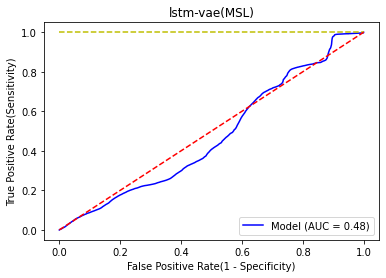

In [100]:
plt.title('lstm-vae(MSL)')
plt.xlabel('False Positive Rate(1 - Specificity)')
plt.ylabel('True Positive Rate(Sensitivity)')

plt.plot(false_positive_rate, true_positive_rate, 'b', label='Model (AUC = %0.2f)'% roc_auc)
plt.plot([0,1],[1,1],'y--')
plt.plot([0,1],[0,1],'r--')

plt.legend(loc='lower right')
plt.savefig('./graph/lstm_vae_MSL.png', dpi=300)
plt.show()